In [2]:
import os
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset , DataLoader
import torchvision.transforms.v2 as transforms
from torchvision import  transforms, models
from PIL import Image 
import torch.optim as optim
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
main_path = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/'

drowsy_paths = [os.path.join(main_path, 'Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Drowsy'))]
non_drowsy_paths = [os.path.join(main_path, 'Non Drowsy', p) for p in os.listdir(os.path.join(main_path, 'Non Drowsy'))]

all_dirs = drowsy_paths +  non_drowsy_paths

random.shuffle(all_dirs)

total_size = len(all_dirs)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  

# Split the data
train_paths = all_dirs[:train_size]
val_paths = all_dirs[train_size:train_size + val_size]
test_paths = all_dirs[train_size + val_size:]

random.shuffle(train_paths)
random.shuffle(val_paths)
random.shuffle(test_paths)

len_all_dirs = len(all_dirs)
len_train_paths = len(train_paths)
len_val_paths = len(val_paths)
len_test_paths = len(test_paths)

print(f"Total images: {len_all_dirs}")
print(f"Training set: {len_train_paths} images")
print(f"Validation set: {len_val_paths} images")
print(f"Test set: {len_test_paths} images")


Total images: 41793
Training set: 33434 images
Validation set: 4179 images
Test set: 4180 images


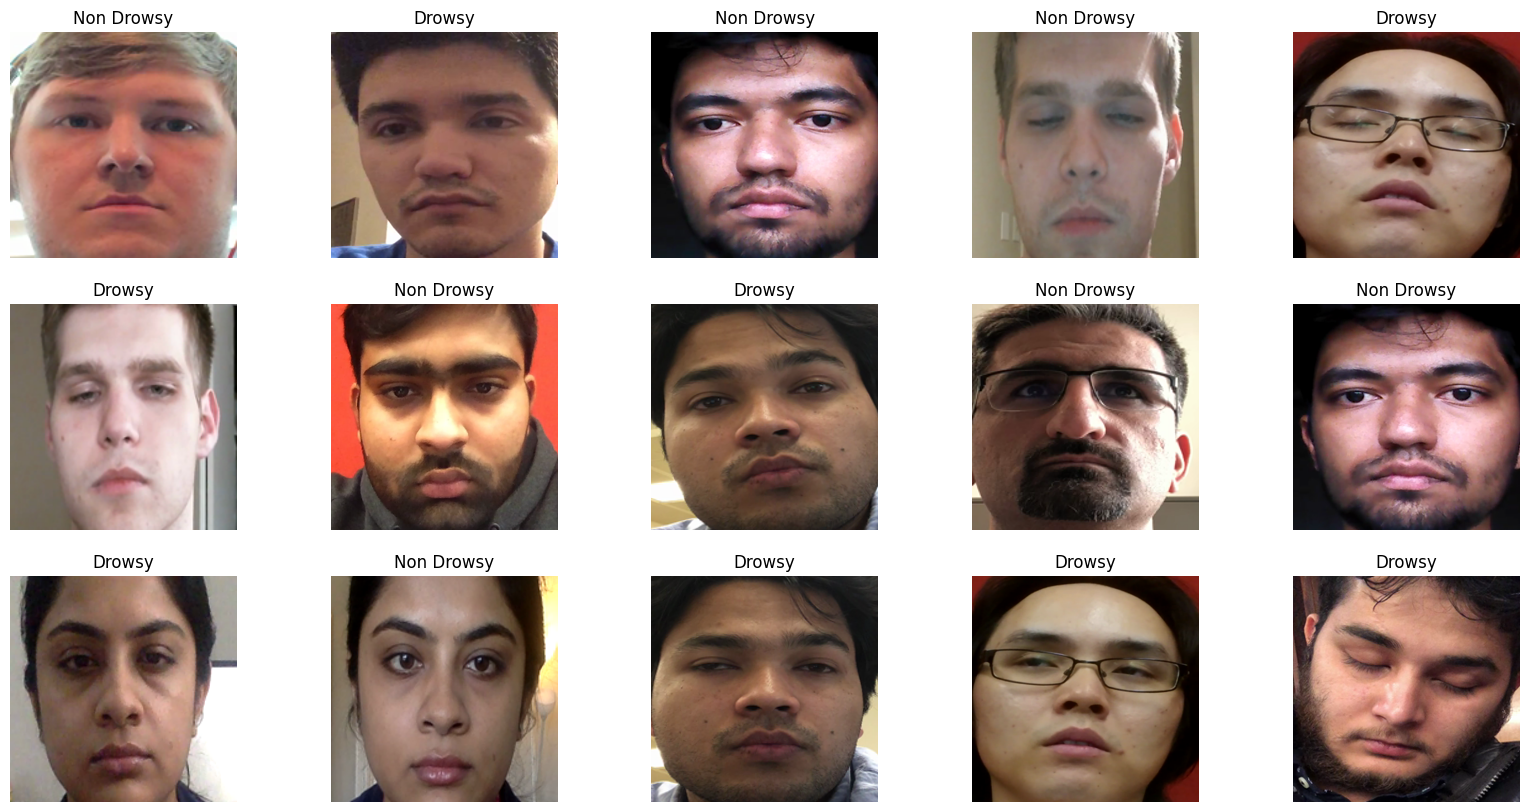

In [4]:
def extract_class_name(p):
    return p.split('/')[-2]
def show_images_with_labels(paths, num_images=15):
    plt.figure(figsize=(20, 10))
    for i, path in enumerate(paths[:num_images]):
        img = Image.open(path)
        label = extract_class_name(path)
        plt.subplot(3, 5, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

show_images_with_labels(train_paths, num_images=15)

In [5]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
    
device = torch.device(dev)  
device

device(type='cuda', index=0)

In [56]:
class MyDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        label = extract_class_name(img_path)

        if self.transform:
            image = self.transform(image = np.array(image))["image"]
        
        label = 0 if label == 'Drowsy' else 1

        return image, label

In [62]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2 
# Define transformation for training data (with augmentation)
train_transform = A.Compose([
    A.Resize(width=224, height=224),
    A.Rotate(limit=30, p=0.5),  # Random rotation within ±30 degrees
    # Perspective transformation. The scale parameter here roughly corresponds to the distortion scale.
    A.Perspective(scale=(0.05, 0.2), keep_size=True, pad_mode=cv2.BORDER_CONSTANT, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
   
])

# Define transformation for validation/test (no augmentation)
test_val_transform = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


In [63]:
train_dataset = MyDataset(train_paths, transform=train_transform)
val_dataset = MyDataset(val_paths, transform=train_transform)
test_dataset = MyDataset(test_paths, transform=test_val_transform)


trainloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=256, shuffle=True)


In [39]:
model = YOLO('yolo11n-cls.pt')
yolo_model = model.model

yolo_model.train()


yolo_model.model[10].linear = nn.Linear(1280, 2)
yolo_model = yolo_model.to(device)
criterion = nn.CrossEntropyLoss()
params_1x = [param for name, param in yolo_model.named_parameters() if not "10.linear" in name]


In [40]:

def evaluate():
    correct = 0
    total = 0
    yolo_model.eval()
    with torch.no_grad():
        #for data in valloader:
        data = next(iter(valloader))
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = yolo_model(images)
        _, predicted = torch.max(outputs[0].data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    yolo_model.train()
    print(f'Accuracy on test images: {100 * correct / total}%')
evaluate()

Accuracy on test images: 50.78125%


In [66]:
#optimizer = optim.Adam([{'params': params_1x}, {'params': yolo_model.model[10].linear.parameters(), 'lr': learning_rate * 10}], lr=learning_rate, betas=(0.9, 0.999))

def train_model(num_epochs, optimizer, trainloader, yolo_model, criterion):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
    
            optimizer.zero_grad()
    
            outputs = yolo_model(inputs)
            loss = criterion(outputs, labels)
    
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            if i%5 == 0:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 5:.3f}')
                running_loss = 0.0
            if i%20 == 0:
                evaluate()

for param in params_1x:
    param.requires_grad = False

optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
train_model(2, optimizer, trainloader, yolo_model, criterion)

for param in params_1x:
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=3e-5, betas=(0.9, 0.999))
train_model(5, optimizer, trainloader, yolo_model, criterion)


[1, 1] loss: 0.063
Accuracy on test images: 90.234375%
[1, 6] loss: 0.316
[1, 11] loss: 0.318
[1, 16] loss: 0.306
[1, 21] loss: 0.302
Accuracy on test images: 89.84375%
[1, 26] loss: 0.290
[1, 31] loss: 0.284
[1, 36] loss: 0.285
[1, 41] loss: 0.281
Accuracy on test images: 89.84375%
[1, 46] loss: 0.271
[1, 51] loss: 0.278
[1, 56] loss: 0.259
[1, 61] loss: 0.259
Accuracy on test images: 92.578125%
[1, 66] loss: 0.241
[2, 1] loss: 0.049
Accuracy on test images: 92.578125%
[2, 6] loss: 0.261
[2, 11] loss: 0.244
[2, 16] loss: 0.243
[2, 21] loss: 0.247
Accuracy on test images: 94.140625%
[2, 26] loss: 0.244
[2, 31] loss: 0.236
[2, 36] loss: 0.240
[2, 41] loss: 0.226
Accuracy on test images: 91.40625%
[2, 46] loss: 0.237
[2, 51] loss: 0.226
[2, 56] loss: 0.231
[2, 61] loss: 0.219
Accuracy on test images: 92.578125%
[2, 66] loss: 0.215
[1, 1] loss: 0.047
Accuracy on test images: 93.359375%
[1, 6] loss: 0.194
[1, 11] loss: 0.172
[1, 16] loss: 0.145
[1, 21] loss: 0.128
Accuracy on test images: 

In [67]:
def evaluate():
    correct = 0
    total = 0
    yolo_model.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = yolo_model(images)
            #print(outputs[0].data)
            _, predicted = torch.max(outputs[0].data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    yolo_model.train()
    print(f'Accuracy on test images: {100 * correct / total}%')
evaluate()

Accuracy on test images: 99.9609375%


In [68]:
torch.save(yolo_model.state_dict(), 'yolov11n_drowsy.pth')